# Overview:

Done:

* Able to get the neuron_output
* Training

To-do:

* for AlexNet, the filter size, stridel, padding size change across different layers --> need to address this?
* pre-trained = True --> is this correct? 
* check if *list method is correct 

References:

https://deeplearning.neuromatch.io/projects/Neuroscience/blurry_vision.html?highlight=alexnet

https://www.kaggle.com/asilvaigor/learning-alexnet

https://www.kaggle.com/drvaibhavkumar/alexnet-in-pytorch-cifar10-clas-83-test-accuracy

https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3?u=klory

https://distill.pub/2017/feature-visualization/

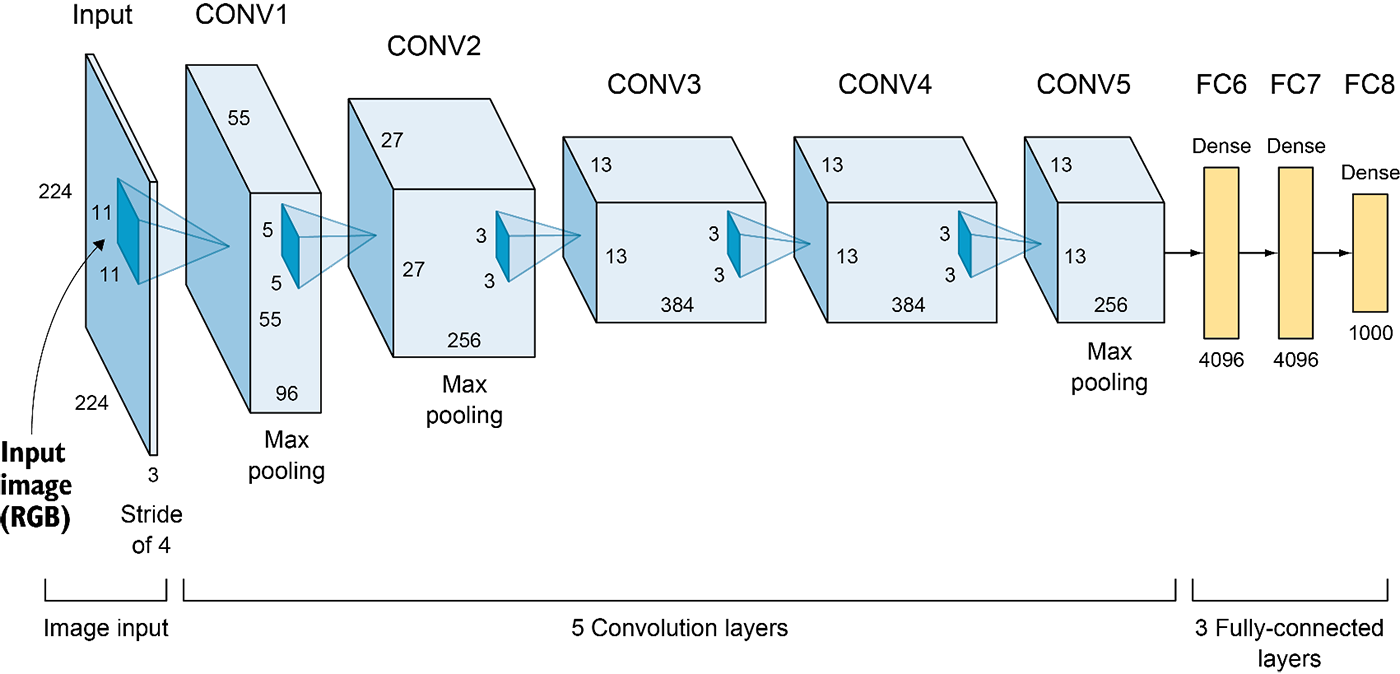

Note that in pytorch linear laryers are initialized in this way:

```
stdv = 1. / math.sqrt(self.weight.size(1))
self.weight.data.uniform_(-stdv, stdv)
if self.bias is not None:
    self.bias.data.uniform_(-stdv, stdv)
```



In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime

# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.7.0
numpy Version: 1.19.5


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K
import math

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import time

In [ ]:
print(torch.__version__)

1.10.0+cu111


In [ ]:
print(torchvision.__version__)

0.11.1+cu111


# Loading CIFAR-10 data:

In [ ]:
transform = transforms.Compose([
    transforms.Resize(128),
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_data[1][0]

tensor([[[ 0.5193,  0.5193,  0.4679,  ..., -0.7479, -0.7650, -0.7650],
         [ 0.5193,  0.5193,  0.4679,  ..., -0.7479, -0.7650, -0.7650],
         [ 0.4851,  0.4851,  0.4508,  ..., -0.7650, -0.7822, -0.7822],
         ...,
         [ 0.6734,  0.6734,  0.6563,  ...,  0.2967,  0.3138,  0.3138],
         [ 0.6734,  0.6734,  0.6563,  ...,  0.3309,  0.3309,  0.3309],
         [ 0.6734,  0.6734,  0.6563,  ...,  0.3309,  0.3309,  0.3309]],

        [[ 1.0630,  1.0630,  0.9755,  ..., -0.6001, -0.6176, -0.6176],
         [ 1.0630,  1.0630,  0.9755,  ..., -0.6001, -0.6176, -0.6176],
         [ 1.0280,  1.0280,  0.9405,  ..., -0.6176, -0.6352, -0.6352],
         ...,
         [ 0.5728,  0.5728,  0.5728,  ...,  0.2577,  0.2752,  0.2752],
         [ 0.5553,  0.5553,  0.5553,  ...,  0.2927,  0.2927,  0.2927],
         [ 0.5553,  0.5553,  0.5553,  ...,  0.2927,  0.2927,  0.2927]],

        [[ 1.4548,  1.4548,  1.3502,  ..., -0.5844, -0.5844, -0.5844],
         [ 1.4548,  1.4548,  1.3502,  ..., -0

In [ ]:
N_train = 50000
N_test = 10000
img_shape = (3, 32, 32) #use a tuple in the fomat: (n_channels, height, width)
n_classes = 10
print(N_train,N_test,img_shape,n_classes)

50000 10000 (3, 32, 32) 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


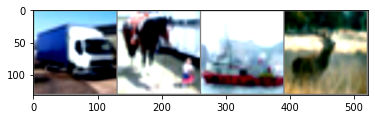

Truck Horse  Ship  Deer


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define AlexNet Model:

In [ ]:
# Define AlexNet with different modules representing different brain areas
class AlexNet(nn.Module):

  def __init__(self, num_classes=1000, downscale=1):
    """
    Args:
      num_classes: int
      downscale: int
    """
    super(AlexNet, self).__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(3, 64//downscale, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(64//downscale, 192//downscale, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(192//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(192//downscale, 384//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384//downscale),
    )
    self.conv_layer4 = nn.Sequential(
        nn.Conv2d(384//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
    )
    self.conv_layer5 = nn.Sequential(
        nn.Conv2d(256//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.it = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256//downscale * 6 * 6, 4096//downscale),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096//downscale, 4096//downscale),
        nn.ReLU(inplace=True)
    )
    self.classifier = nn.Linear(4096//downscale, num_classes)

  def forward(self, x):
    """
    Args:
      x: torch.Tensor
    Returns:
      x: torch.Tensor
    """
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = self.conv_layer4(x)
    x = self.conv_layer5(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.it(x)
    x = self.classifier(x)
    return x

In [ ]:
AlexNet_Model = AlexNet(num_classes=10, downscale=2)
AlexNet_Model.eval()

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_Model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
AlexNet_Model.to(device)

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

# Load saved models for epochs 0, 1, 5, 10, 15, 20, 25:

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Embeddings/code'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Embeddings/code


In [ ]:
AlexNet_Model_epoch0 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch0.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch0.pt'))
AlexNet_Model_epoch0.to(device)

AlexNet_Model_epoch1 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch1.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch1.pt'))
AlexNet_Model_epoch1.to(device)

AlexNet_Model_epoch5 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch5.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch5.pt'))
AlexNet_Model_epoch5.to(device)

AlexNet_Model_epoch10 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch10.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch10.pt'))
AlexNet_Model_epoch10.to(device)

AlexNet_Model_epoch15 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch15.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch15.pt'))
AlexNet_Model_epoch15.to(device)

AlexNet_Model_epoch20 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch20.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch20.pt'))
AlexNet_Model_epoch20.to(device)

AlexNet_Model_epoch25 = AlexNet(num_classes=10, downscale=2)
AlexNet_Model_epoch25.load_state_dict(torch.load('/content/drive/My Drive/Embeddings/code/AlexNet_Model_epoch25.pt'))
AlexNet_Model_epoch25.to(device)

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

# Get accuracy:

In [ ]:
# define function to calculate current accuracy with a given dataloader
def accuracy(dataloader, device='cpu'): #Get the accuracies
  net.eval()
  correct = 0
  count = 0
  for data, target in tqdm.tqdm(dataloader):
    data = data.to(device).float()
    target = target.to(device).long()

    prediction = net(data)
    _, predicted = torch.max(prediction, 1)
    count += target.size(0)
    correct += (predicted == target).sum().item()

  acc = 100 * correct / count
  return count, acc


# define function to evaluate and print training and test accuracy
def evaluate(net, device='cpu', title=""):
  net.eval()
  train_count, train_acc = accuracy(clear_train_batches, device=device)
  test_count, test_acc = accuracy(clear_test_batches, device=device)
  print(f'Accuracy on the {train_count} clear training samples {title}: {train_acc:0.2f}')
  print(f'Accuracy on the {test_count} clear testing samples {title}: {test_acc:0.2f}')
  train_count, train_acc = accuracy(noisy_train_batches, device=device)
  test_count, test_acc = accuracy(noisy_test_batches, device=device)
  print(f'Accuracy on the {train_count} blurry training samples {title}: {train_acc:0.2f}')
  print(f'Accuracy on the {test_count} blurry testing samples {title}: {test_acc:0.2f}')

# Visualizing filters:

In [ ]:
def show_weights(layer, i=0):
    filter = layer[0].weight.cpu().data
    filter = (1 / (2 * filter.max())) * filter + 0.5 #Normalizing the values to [0,1]
    print(filter.shape)
    img = torchvision.utils.make_grid(filter)
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 11, 11])
(54, 106, 3)


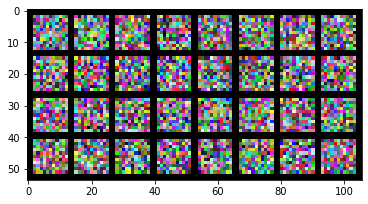

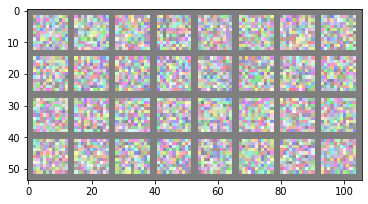

In [ ]:
show_weights(AlexNet_Model.conv_layer1)

# Visualizing outputs given an image: 

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


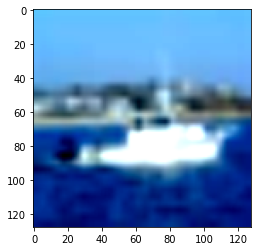

In [ ]:
imshow(images[0])

In [ ]:
images = images.type(torch.cuda.FloatTensor)
im = images[0].unsqueeze(0)

In [ ]:
im.shape

torch.Size([1, 3, 128, 128])

In [ ]:
!pip install torch_intermediate_layer_getter

In [ ]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
return_layers = {
    # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
      'conv_layer1': 'conv_layer1',
      'conv_layer3': 'conv_layer3',
      'conv_layer5': 'conv_layer5',
  }
net = AlexNet_Model
LayerGetter = torchvision.models._utils.IntermediateLayerGetter(net, return_layers=return_layers)
intermediate_output = LayerGetter(im)
print(intermediate_output['conv_layer1'].shape)

torch.Size([1, 32, 15, 15])


Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer1')

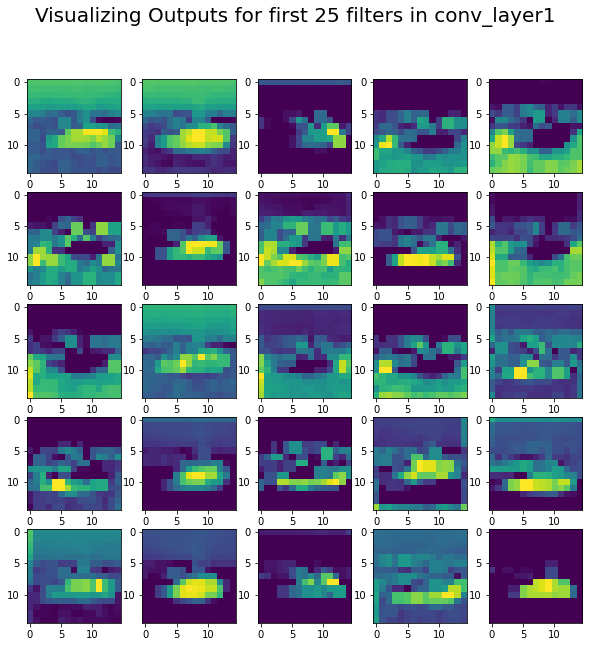

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer1'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer1', fontsize=20)

# Visualizing embeddings:

In [ ]:
def apply_all_shifts(im, shift_step):
    '''
    arg(s): 
        DEBUG NOTE: PYTORCH IS (#channels, rows, cols)!!
        im, an image of shape (3, im_size, im_size)
    return: 
        im_all_shifts, a list of all shifted images from the input image
        n_shifts, number of shifted images
    '''
    
    ## vertical size might not be the same as the horizontal
    im_size_vertical = im.shape[1]
    im_size_horizontal = im.shape[2]
    
    n_shifts_vertical = int(math.ceil(im_size_vertical/ shift_step))
    n_shifts_horizontal = int(math.ceil(im_size_horizontal/ shift_step))
    
    im_all_shifts = []
    im_shift = im
    for i in range(n_shifts_vertical):
        im_shift = np.roll(im_shift, shift = shift_step * i, axis=1)
        
        for j in range(n_shifts_horizontal):
            im_shift = np.roll(im_shift, shift = shift_step * j, axis=2)
            im_all_shifts.append(im_shift)
            
    im_all_shifts =  np.array(im_all_shifts)
    return im_all_shifts, n_shifts_vertical * n_shifts_horizontal

In [ ]:
def compute_neuron_output_alt(model, layer_names, images, max10_indices = None):

    '''
    arg(s):
        layer_names: list of strings indicating the names of the layers we want to take neuron outputs from
        images: a tensor of images (stimuli)
    return:
        
    '''
    n_images = images.shape[0]
    n_layers = len(layer_names)
    neuron_output_highest = []
    all_fm_avg = []
    neuron_labels = []
    images = images.type(torch.cuda.FloatTensor)
    
    layer_index = 1
    for layer_name in layer_names:
        ## note: always take the images as inputs
        return_layers = {layer_name: layer_name}
        LayerGetter = torchvision.models._utils.IntermediateLayerGetter(model, return_layers=return_layers)
        neuron_output = []
        for i in range(n_images):
            im = images[i]
            im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))
            output = LayerGetter(im)
            output = output[layer_name] 
            neuron_output.append(output)
        neuron_output =  torch.stack(neuron_output)
        neuron_output = neuron_output.reshape((neuron_output.shape[0], neuron_output.shape[2], neuron_output.shape[3], neuron_output.shape[4]))

        neuron_output = neuron_output.permute(0, 2, 3, 1)
        
        ## number of neurons is nrow * ncol * n_feature_maps
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        
        ## remove the neurons at the edges
        neuron_output = neuron_output[:,2:(n_row-2),2:(n_col-2),:]
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        neuron_output = neuron_output.reshape((n_images, n_row * n_col, n_feature_maps))
        n_neurons = n_row * n_col
        
        # neuron_index = np.empty((n_row,n_col),dtype=int)
        # index = 0
        # for i in range(n_row):
        #     for j in range(n_col):
        #         neuron_index[i, j] = index
        #         index += 1
                
        # ## obtain the index of the neurons at the edges
        # neuron_edge_index = np.hstack((neuron_index[[0,1,n_row-2,n_row-1],:].reshape((4*32,1)), neuron_index[:,[0,1,n_col-2,n_col-1]].reshape((4*32,1))))
        # neuron_edge_index = neuron_edge_index.reshape((256,1))
        

        # ## re-label the neurons at the edge with a different color
        # neuron_labels = []
        # for i in range(10):    
        #     neuron_labels = np.hstack((neuron_labels, [i] * n_neurons))
        #     neuron_labels = np.array(neuron_labels)
        #     neuron_labels[n_neurons * i + neuron_edge_index-1] = 15
        
        # neuron_output = neuron_output.reshape((n_images, n_neurons, n_feature_maps))
        
        ## transpose to organize by feature maps
        ## neuron_output_by_fm is (n_images, n_feature_maps, #neurons)
        neuron_output_by_fm = neuron_output.permute(0, 2, 1)
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg is (n_images, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]
        
        if layer_index == 1: 
            fm_avg_all_layers = fm_avg
            neuron_output_by_fm_all_layers = neuron_output_by_fm
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
            neuron_output_by_fm_all_layers = np.concatenate((neuron_output_by_fm_all_layers,neuron_output_by_fm), axis = 1)

    neuron_output_highest = np.empty((n_images,n_neurons *10))
    fm_avg_all_layers = fm_avg_all_layers.cpu().data
    neuron_output_by_fm_all_layers = neuron_output_by_fm_all_layers.cpu().data
    
    for i in range(n_images):
        if max10_indices is None:
            max10_indices = np.argpartition(fm_avg_all_layers[i], -10, axis = 0)[-10:]
            
        neuron_output_highest[i] = neuron_output_by_fm_all_layers[i, max10_indices, :].reshape((1,n_neurons *10))

    for i in range(10):    
        neuron_labels += [i] * n_neurons

    neuron_labels = np.array(neuron_labels)  


    return neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices

In [ ]:
def show_stimuli(model, layer_names, images_selected_classes, shifts, max10_indices):
    '''
    arg(s): 
        layer_indices, interested layers
        images_selected_classes, all the selected images
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''
    
    # images_selected_classes = np.array(images_selected_classes)
    n_images_selected_classes = 40

    if shifts is False:
        neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices = compute_neuron_output_alt(model, layer_names, images_selected_classes, max10_indices = max10_indices)
  
    else: 
        # generate shifts for each selected image: 
        neuron_output_highest_with_shifts = []
        fm_avg_all_layers_with_shifts = []
        for i in range(n_images_selected_classes):
            im = images_selected_classes[i]
            ## DEBUG NOTE: since the images need to be resized to 224x224, shift_step should be larger to prevent crashes
            im_all_shifts, n_shifts =  apply_all_shifts(im, 10)

            im_all_shifts = torch.Tensor(im_all_shifts)

            ## neuron_output_highest is of shape (number of shifts, neurons)
            neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices = compute_neuron_output_alt(model, layer_names, im_all_shifts, max10_indices = max10_indices)
             
            if shifts is False:
                neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices = compute_neuron_output_alt(model, layer_names, images_selected_classes, max10_indices = max10_indices)
    
            else:
                # generate shifts for each selected image: 
                neuron_output_highest_with_shifts = []
                fm_avg_all_layers_with_shifts = []
                for i in range(n_images_selected_classes):
                    im = images_selected_classes[i]
                    im_all_shifts, n_shifts =  apply_all_shifts(im, 4)
                    im_all_shifts = torch.Tensor(im_all_shifts)

                    ## neuron_output_highest is of shape (number of shifts, neurons)
                    neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices = compute_neuron_output_alt(model, layer_names, im_all_shifts, max10_indices = max10_indices)
                  
                    ## take the average over all shifts of im
                    shifts_avg = neuron_output_highest.sum(axis=0) / neuron_output_highest.shape[0]
                    shifts_avg = shifts_avg.reshape((1,shifts_avg.shape[0]))
                  
                    fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
                    fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
                  
                    if i == 0:
                        neuron_output_highest_with_shifts = shifts_avg 
                        fm_avg_all_layers_with_shifts = fm_shifts_avg
                    else:
                        neuron_output_highest_with_shifts = np.vstack((neuron_output_highest_with_shifts, shifts_avg))
                        fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
                      
                neuron_output_highest = neuron_output_highest_with_shifts
                fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest, fm_avg_all_layers, neuron_labels, max10_indices

Take 40 images, 10 images each in the airplane, automobile, cat, dog classes:

In [ ]:
airplane_indices, automobile_indices, cat_indices, dog_indices = [], [], [], []
airplane_idx, automobile_idx, cat_idx, dog_idx = train_data.class_to_idx['airplane'], train_data.class_to_idx['automobile'], train_data.class_to_idx['cat'], train_data.class_to_idx['dog']

i = 0
while(len(airplane_indices) < 10 or len(automobile_indices) < 10 or len(cat_indices) < 10 or len(dog_indices) < 10):
    current_class = train_data[i][1]
    if current_class == airplane_idx:
        airplane_indices.append(i)
    elif current_class == automobile_idx:
        automobile_indices.append(i)
    elif current_class == cat_idx:
        cat_indices.append(i)
    elif current_class == dog_idx:
        dog_indices.append(i)
    i += 1

airplane_indices = airplane_indices[0:10]
automobile_indices = automobile_indices[0:10]
cat_indices = cat_indices[0:10]
dog_indices = dog_indices[0:10]
selected_train_data = Subset(train_data, airplane_indices + automobile_indices + cat_indices + dog_indices)
n_images = 40

In [ ]:
# get some random training images
trainloader_images_selected_classes = torch.utils.data.DataLoader(selected_train_data, batch_size=n_images, shuffle=False, num_workers=2)
dataiter_images_selected_classes = iter(trainloader_images_selected_classes)
images_selected_classes, labels_selected_classes = dataiter_images_selected_classes.next()

In [ ]:
images_selected_classes.shape

torch.Size([40, 3, 128, 128])

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max10_indices = show_stimuli(AlexNet_Model_epoch25, ['conv_layer1'], images_selected_classes, shifts = True, max10_indices = None)

In [ ]:
neuron_output_highest_with_shifts.shape

(40, 1210)

In [ ]:
max10_indices

tensor([10,  0, 13, 11,  7,  4, 28, 29, 12, 14])

## Save and load .mat data for TCA:

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (1, 0))

In [ ]:
data.shape
# (#neurons, #images_selected_classes, #shifts)

(1210, 40)

In [ ]:
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
mdic

{'neuron_output_2D': array([[-0.26552739, -0.34358546, -0.13261588, ..., -0.23939747,
         -0.20428174, -0.17908547],
        [-0.23318642, -0.35282315, -0.16474112, ..., -0.27070811,
         -0.23322494, -0.16783827],
        [-0.24617077, -0.34496701, -0.20551104, ..., -0.30336041,
         -0.21468199, -0.19419357],
        ...,
        [ 0.08788887, -0.02612015,  0.06856107, ...,  0.09797767,
          0.04931487,  0.07402897],
        [ 0.08501417, -0.04731033,  0.06372763, ...,  0.09829246,
          0.08242513,  0.09299901],
        [ 0.00376375, -0.07187743,  0.06819594, ...,  0.08119232,
          0.06991663,  0.09049458]])}

In [ ]:
savemat("neuron_output_2D_epoch25.mat", mdic)

In [ ]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_2D_epoch25.mat')['F']

In [ ]:
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(1210, 10)

In [ ]:
neuron_labels = []
n_neurons = 121
for i in range(10):    
    neuron_labels += [i] * n_neurons

neuron_labels = np.array(neuron_labels) 

In [ ]:
print(neuron_labels.shape)

(1210,)


## Plot embedding:

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


## Zoom in to one cluster and color by position:

1. use these same plots, to show positional coordinates
2. repeat training with no shifts 
(but compute activcations with shifts to create tensors - use shift step 4)
  - 3d tensor --> run embeddings 
  (array too large even for 20 images)
  - 2d tensor (3rd dim averaged) --> run embeddings (should produce tighter clusters)

3. try bigger images (e.g. cropping imagenet)

In [ ]:
neuron_cluster1 = neuron_output_highest_with_shifts_projected[121*2:121*3]
neuron_label1 = neuron_labels[121*2:121*3]

In [ ]:
neuron_cluster1

array([[-0.09182299,  0.00440885, -0.00447467, ..., -0.00140274,
         0.0071821 ,  0.01130448],
       [-0.0918004 ,  0.00343564, -0.00551669, ..., -0.001517  ,
         0.00703428,  0.01543196],
       [-0.0917962 ,  0.00325081, -0.00571448, ..., -0.00153853,
         0.00700622,  0.01621624],
       ...,
       [-0.09176454,  0.00392706, -0.00504965, ..., -0.00155262,
         0.00710649,  0.01313194],
       [-0.09112651,  0.00141138, -0.00846831, ..., -0.00299246,
         0.00669452,  0.02115352],
       [-0.09176766,  0.00201681, -0.00703562, ..., -0.00168323,
         0.00681879,  0.0214502 ]])

In [ ]:
neuron_label1.shape

(121,)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_cluster1

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_label1 == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 0
1 0
2 121
3 0
4 0
5 0
6 0
7 0
8 0
9 0


In [ ]:
neuron_cluster1.shape

(121, 10)

In [ ]:
xs, ys = np.mgrid[0:11,0:11]
xs = xs.reshape((121,))
ys = ys.reshape((121,))

In [ ]:
xs

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10])

In [ ]:
ys

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10])

In [ ]:
def colorFromUnivariateData(Z1, cmap1 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)

    # Color for each point
    Z_color = np.array(Z1_color[:,0:3])
    return Z_color

In [ ]:
## ## https://stackoverflow.com/questions/49871436/scatterplot-with-continuous-bivariate-color-palette-in-python

def colorFromBivariateData(Z1,Z2,cmap1 = plt.cm.Blues, cmap2 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)
    Z2_plot = np.array(255*(Z2-Z2.min())/(Z2.max()-Z2.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color , Z2_color ], axis=0)/2.0
    Z_color = np.array(Z_color[:,0:3])
    return Z_color

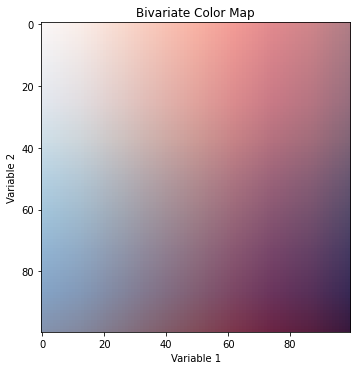

In [ ]:
def colorFromBivariateData_plot(Z1,Z2,cmap1 = plt.cm.Blues, cmap2 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)
    Z2_plot = np.array(255*(Z2-Z2.min())/(Z2.max()-Z2.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color, Z2_color], axis=0)/2.0

    return Z_color

z1 = np.random.random((50,100))
z2 = np.random.random((50,100))
Z_color = colorFromBivariateData_plot(z1,z2)

xx, yy = np.mgrid[0:100,0:100]
C_map = colorFromBivariateData_plot(xx,yy)

fig = plt.figure(figsize=(10,5))

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(C_map)
ax2.set_title('Bivariate Color Map')
ax2.set_xlabel('Variable 1')
ax2.set_ylabel('Variable 2')

fig.tight_layout()
fig.show()

In [ ]:
color_result = colorFromBivariateData(xs,ys)
color_result.shape

(121, 3)

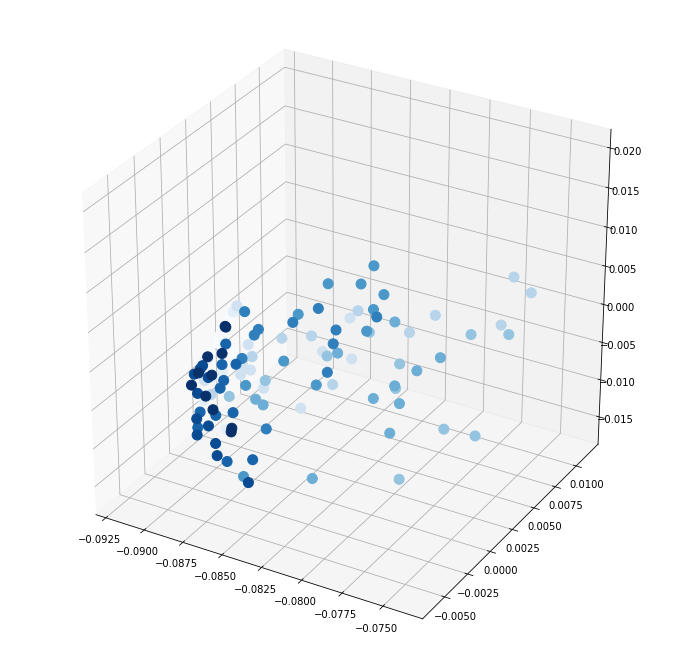

In [ ]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
        s = 100,
        alpha= 1
        ) 

plt.show()

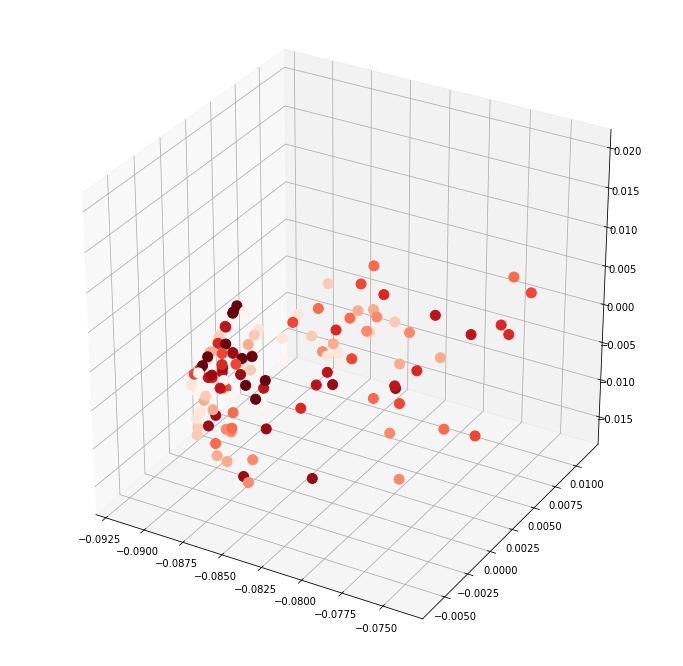

In [ ]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
        s = 100,
        alpha= 1
        ) 

plt.show()

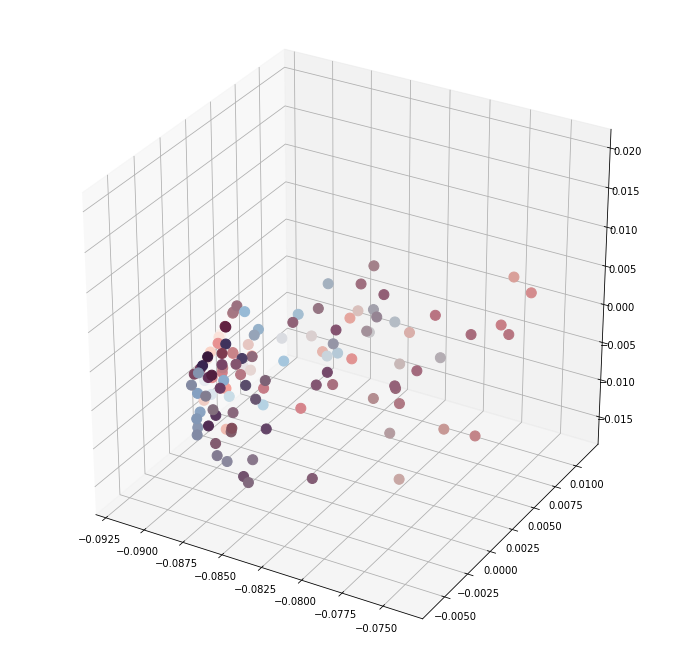

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(projection='3d')
data = neuron_cluster1 
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        )

plt.show()

# Afet FMs are fixed:

## Epoch 20:

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max10_indices = show_stimuli(AlexNet_Model_epoch20, ['conv_layer1'], images_selected_classes, shifts = True, max10_indices = max10_indices)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (1, 0))
print(data.shape)
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
savemat("neuron_output_2D_epoch20.mat", mdic)

(1210, 40)


In [ ]:
F = loadmat('factors_opt_nonneg_2D_epoch20.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

neuron_labels = []
n_neurons = 121
for i in range(10):    
    neuron_labels += [i] * n_neurons
neuron_labels = np.array(neuron_labels) 
print(neuron_labels.shape)

(1210,)


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


In [ ]:
neuron_cluster1 = neuron_output_highest_with_shifts_projected[121*2:121*3]
neuron_label1 = neuron_labels[121*2:121*3]
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_cluster1

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_label1 == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()


0 0
1 0
2 121
3 0
4 0
5 0
6 0
7 0
8 0
9 0


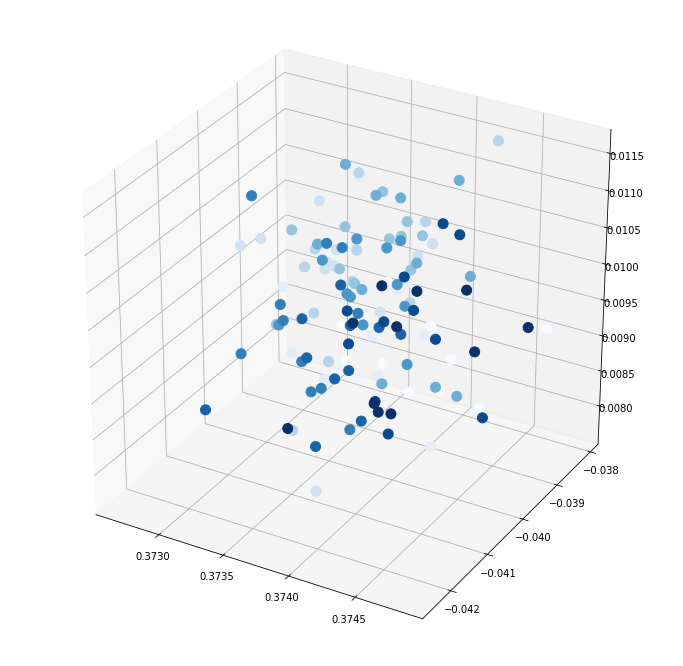

In [ ]:
xs, ys = np.mgrid[0:11,0:11]
xs = xs.reshape((121,))
ys = ys.reshape((121,))
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
        s = 100,
        alpha= 1
        ) 

plt.show()

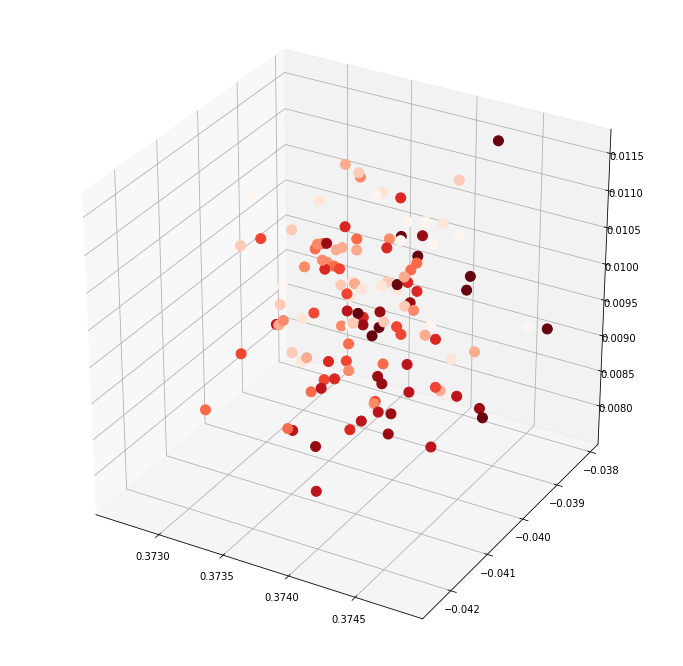

In [ ]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
        s = 100,
        alpha= 1
        ) 

plt.show()

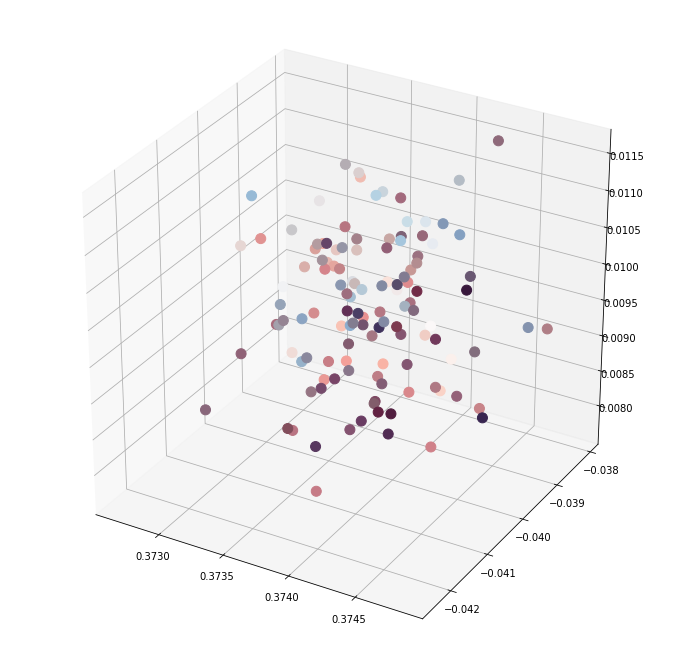

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(projection='3d')
data = neuron_cluster1 
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        )

plt.show()

## Epoch 15:

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max10_indices = show_stimuli(AlexNet_Model_epoch15, ['conv_layer1'], images_selected_classes, shifts = True, max10_indices = max10_indices)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (1, 0))
print(data.shape)
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
savemat("neuron_output_2D_epoch15.mat", mdic)

(1210, 40)


In [ ]:
F = loadmat('factors_opt_nonneg_2D_epoch15.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

neuron_labels = []
n_neurons = 121
for i in range(10):    
    neuron_labels += [i] * n_neurons
neuron_labels = np.array(neuron_labels) 
print(neuron_labels.shape)

(1210,)


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


In [ ]:
neuron_cluster1 = neuron_output_highest_with_shifts_projected[121*2:121*3]
neuron_label1 = neuron_labels[121*2:121*3]
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_cluster1

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_label1 == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()


0 0
1 0
2 121
3 0
4 0
5 0
6 0
7 0
8 0
9 0


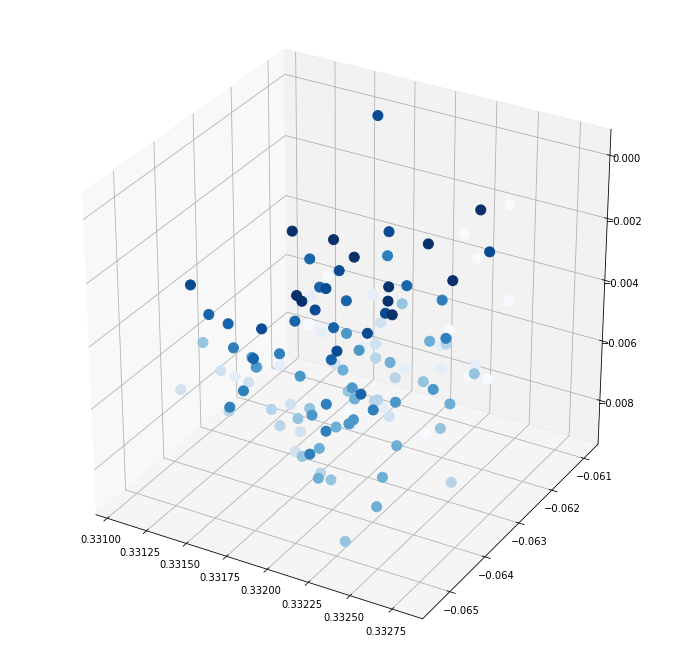

In [ ]:
xs, ys = np.mgrid[0:11,0:11]
xs = xs.reshape((121,))
ys = ys.reshape((121,))
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
        s = 100,
        alpha= 1
        ) 

plt.show()

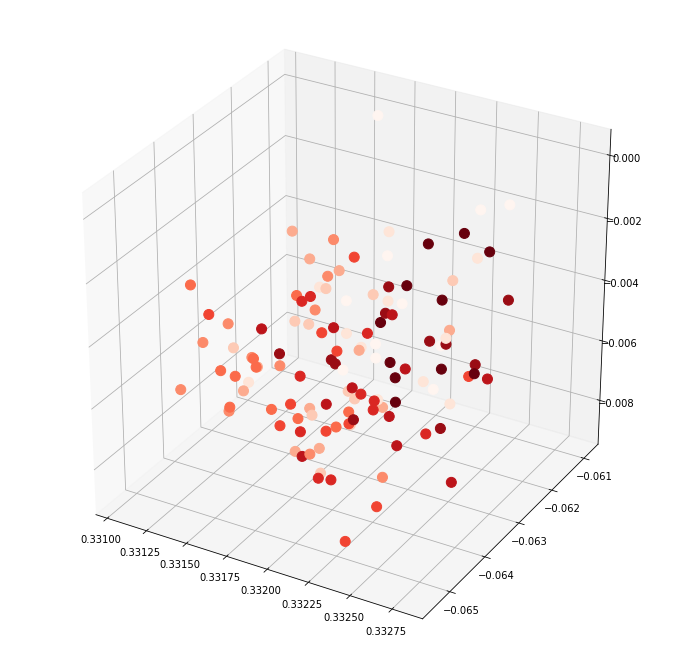

In [ ]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
        s = 100,
        alpha= 1
        ) 

plt.show()

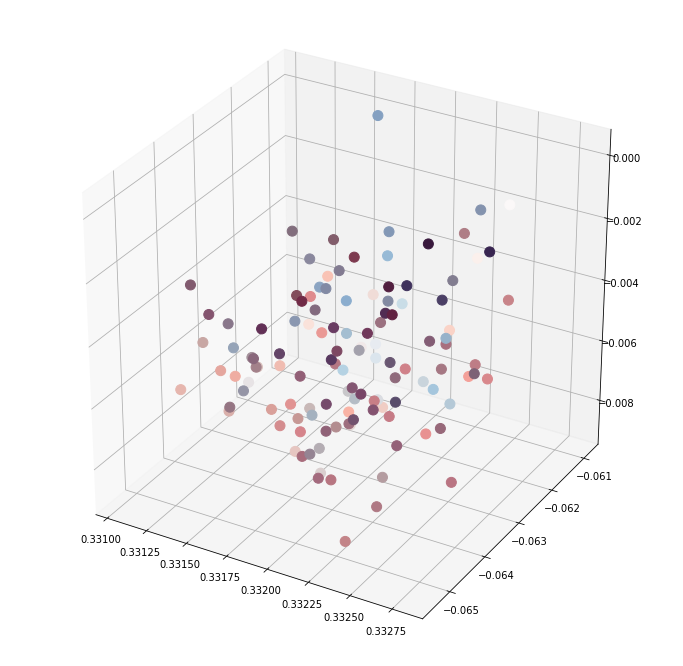

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(projection='3d')
data = neuron_cluster1 
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        )

plt.show()

## Epoch 10:

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max10_indices = show_stimuli(AlexNet_Model_epoch10, ['conv_layer1'], images_selected_classes, shifts = True, max10_indices = max10_indices)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (1, 0))
print(data.shape)
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
savemat("neuron_output_2D_epoch10.mat", mdic)

(1210, 40)


In [ ]:
F = loadmat('factors_opt_nonneg_2D_epoch10.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

neuron_labels = []
n_neurons = 121
for i in range(10):    
    neuron_labels += [i] * n_neurons
neuron_labels = np.array(neuron_labels) 
print(neuron_labels.shape)

(1210,)


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


In [ ]:
neuron_cluster1 = neuron_output_highest_with_shifts_projected[121*2:121*3]
neuron_label1 = neuron_labels[121*2:121*3]
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_cluster1

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_label1 == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()


0 0
1 0
2 121
3 0
4 0
5 0
6 0
7 0
8 0
9 0


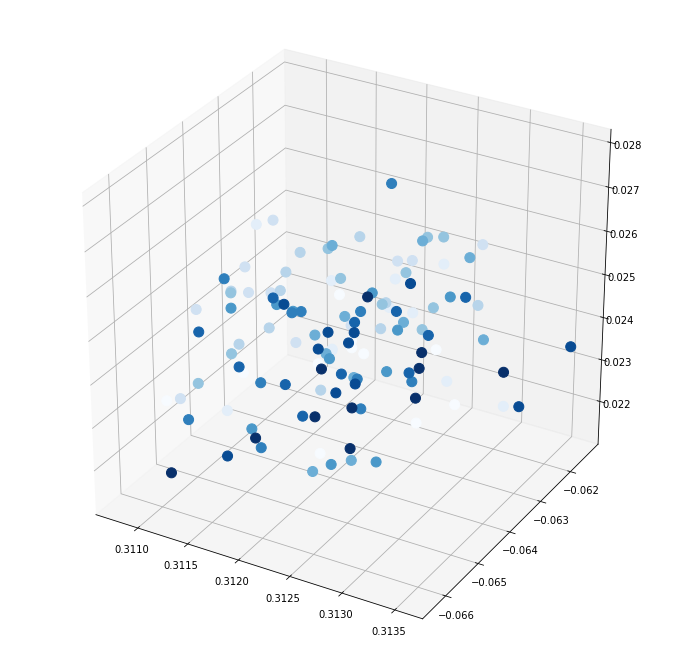

In [ ]:
xs, ys = np.mgrid[0:11,0:11]
xs = xs.reshape((121,))
ys = ys.reshape((121,))
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
        s = 100,
        alpha= 1
        ) 

plt.show()

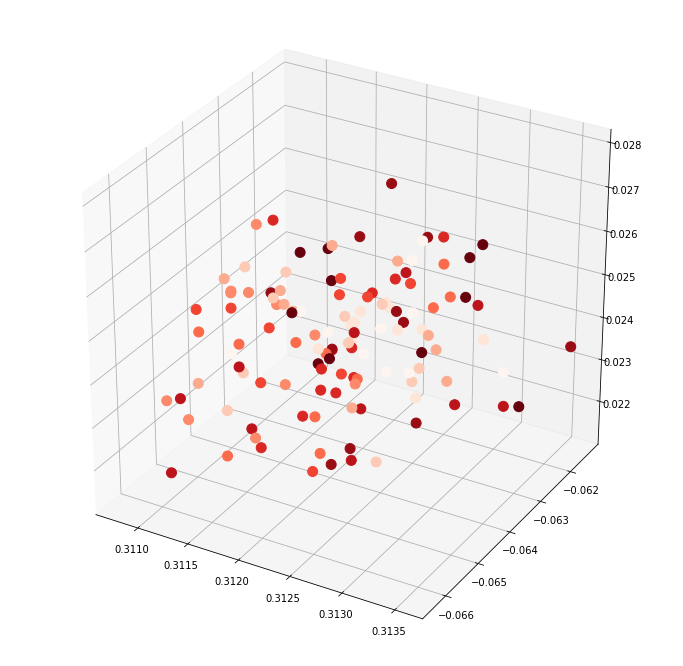

In [ ]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
        s = 100,
        alpha= 1
        ) 

plt.show()

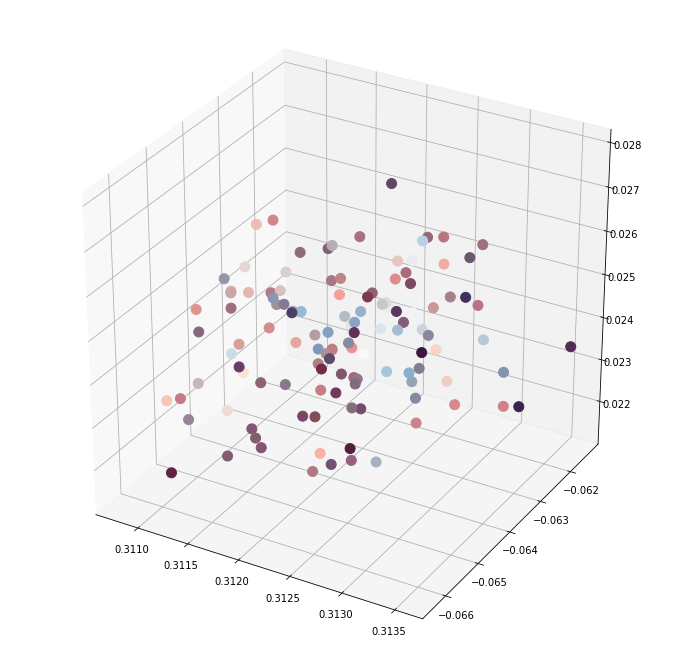

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(projection='3d')
data = neuron_cluster1 
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        )

plt.show()

## Epoch 5:

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max10_indices = show_stimuli(AlexNet_Model_epoch5, ['conv_layer1'], images_selected_classes, shifts = True, max10_indices = max10_indices)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (1, 0))
print(data.shape)
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
savemat("neuron_output_2D_epoch5.mat", mdic)

(1210, 40)


In [ ]:
F = loadmat('factors_opt_nonneg_2D_epoch5.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

neuron_labels = []
n_neurons = 121
for i in range(10):    
    neuron_labels += [i] * n_neurons
neuron_labels = np.array(neuron_labels) 
print(neuron_labels.shape)

(1210,)


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


In [ ]:
neuron_cluster1 = neuron_output_highest_with_shifts_projected[121*2:121*3]
neuron_label1 = neuron_labels[121*2:121*3]
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_cluster1

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_label1 == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()


0 0
1 0
2 121
3 0
4 0
5 0
6 0
7 0
8 0
9 0


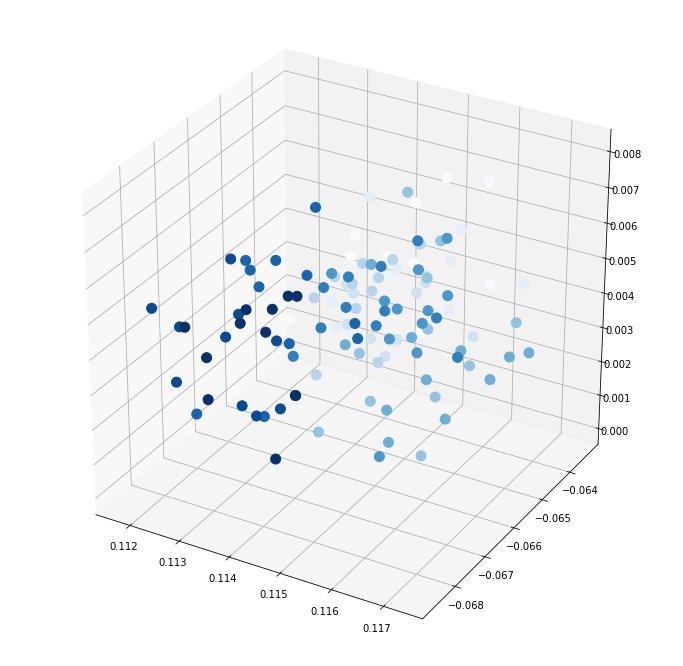

In [ ]:
xs, ys = np.mgrid[0:11,0:11]
xs = xs.reshape((121,))
ys = ys.reshape((121,))
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
        s = 100,
        alpha= 1
        ) 

plt.show()

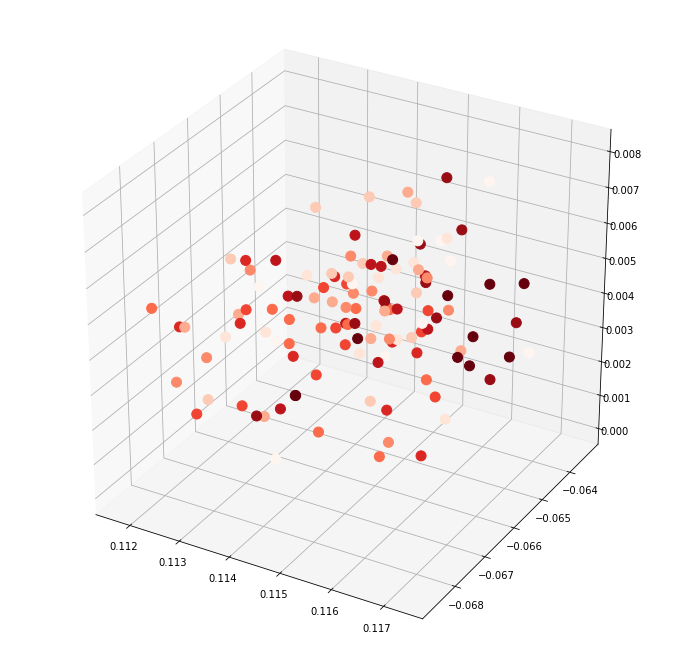

In [ ]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
        s = 100,
        alpha= 1
        ) 

plt.show()

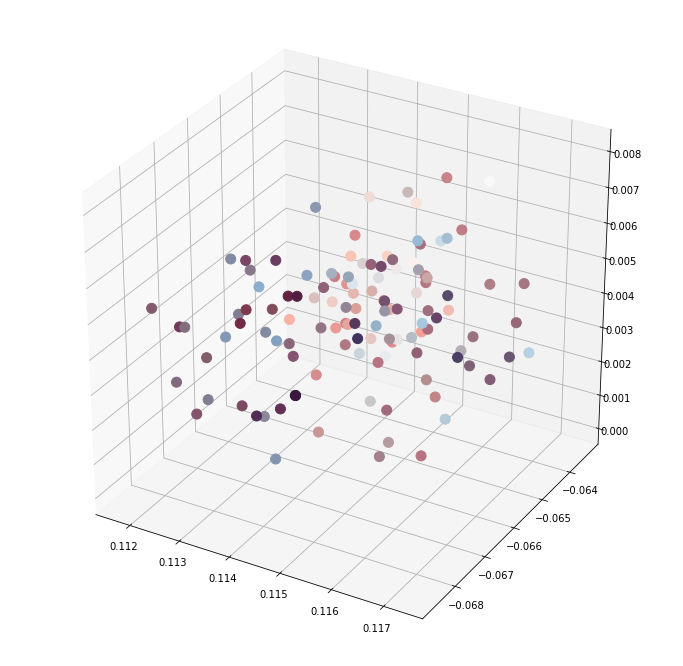

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(projection='3d')
data = neuron_cluster1 
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        )

plt.show()

## Epoch 0:

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels, max10_indices = show_stimuli(AlexNet_Model_epoch0, ['conv_layer1'], images_selected_classes, shifts = True, max10_indices = max10_indices)

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (1, 0))
print(data.shape)
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
savemat("neuron_output_2D_epoch0.mat", mdic)

(1210, 40)


In [ ]:
F = loadmat('factors_opt_nonneg_2D_epoch0_fixed.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

neuron_labels = []
n_neurons = 121
for i in range(10):    
    neuron_labels += [i] * n_neurons
neuron_labels = np.array(neuron_labels) 
print(neuron_labels.shape)

(1210,)


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


In [ ]:
neuron_cluster1 = neuron_output_highest_with_shifts_projected[121*2:121*3]
neuron_label1 = neuron_labels[121*2:121*3]
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_cluster1

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_label1 == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()


In [ ]:
xs, ys = np.mgrid[0:11,0:11]
xs = xs.reshape((121,))
ys = ys.reshape((121,))
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
        s = 100,
        alpha= 1
        ) 

plt.show()

In [ ]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
        s = 100,
        alpha= 1
        ) 

plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(projection='3d')
data = neuron_cluster1 
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        )

plt.show()